# Model Training
Where I train the model

In [13]:
import torch
from torch import optim
from torch import nn
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


from cnn.models import Model
from data.import_data import load_dataset, get_dataloader
from eval import eval_model

## Device, Loss Function

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.BCELoss()

## Loading Data

In [3]:
# load in TensorDatasets -- these will then be used to populate the dataloaders

train_dataset = load_dataset('data/meta/train.csv', files_to_load=1000)
test_dataset = load_dataset('data/meta/test.csv', files_to_load=1000)

## Hyperparameters

In [4]:
# define our hyperparameter options
## these will be used for some basic hyperparameter tuning

num_channels_list = [4, 8, 16, 32, 64, 128]
lrs_list = [.001, .0005, .0001]
bses_list = [8, 16, 32, 64, 128]

epochs = 100

## Training

In [10]:
def train(num_channels, learning_rate, batch_size, epochs,
          display=False):
    '''
    Trains a model with the given hyperparameters.

    Parameters
    ----------
    num_channels : int
        The number of channels to use in the model.
    learning_rate : float
        The learning rate to use in the optimizer.
    batch_size : int
        The batch size to use in the dataloaders.
    epochs : int
        The number of epochs to train for.
    display : bool | False
        Whether or not to plot the loss over time and display it.

    Returns
    -------
    model : Model
        The trained model.
    '''

    # get the dataloaders
    train_loader = get_dataloader(train_dataset, batch_size=batch_size)
    test_loader = get_dataloader(test_dataset, batch_size=batch_size)

    # define the model
    model = Model(num_channels=num_channels).to(device)

    # define the optimizer
    opt = optim.Adam(model.parameters(), lr=learning_rate)

    # keep track of the losses - to plot loss over time, as well as to use for early stopping
    train_losses = []
    test_losses = []

    # train the model
    for epoch in range(epochs):

        # set the model to train mode
        model.train()
        train_loss = 0

        # iterate over the training data
        for inputs, targets in train_loader:
            preds = model(inputs)
            
            loss = loss_func(preds, targets)
            train_loss += loss.item()
                    
            opt.zero_grad()
                
            loss.backward()
            opt.step()
        
        train_losses.append(train_loss)

        # set the model to evaluation mode
        model.eval()

        # calculate the test loss
        with torch.no_grad():
            test_loss = 0
            for inputs, targets in test_loader:
                preds = model(inputs)
                test_loss += loss_func(preds, targets).item()
            
            test_losses.append(test_loss)

            print(f'Epoch: {epoch} | Test Loss: {test_loss}')
        
        # early stopping
        # let it train for at least 3 epochs before stopping
        if epoch > 3:
            # look at the last 3 test losses - if all of them are greater than the min test loss, stop training
            ## i.e. if the model has not had any improvement in the last 3 epochs, stop training
            if all(val > min(test_losses) for val in list(test_losses[-3:])):
                print('Stopping early...')
                break
        
    # plot the loss over time
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()
    plt.show()
    
    return model

In [11]:
trained_model = train(16, .0001, 128, 20)

Epoch: 0 | Test Loss: 26.315618634223938
Epoch: 1 | Test Loss: 27.18991506099701
Epoch: 2 | Test Loss: 27.49413949251175
Epoch: 3 | Test Loss: 26.290574729442596


KeyboardInterrupt: 

## Model Evaluation

Optimal Threshold: 0.767863929271698
ROC: 0.5323782199162177
Accuracy: 0.4486948694869487
Sensitivity: 0.8421418636995828
Specificity: 0.26047904191616766
PPV: 0.3526499708794409
NPV: 0.7752475247524753


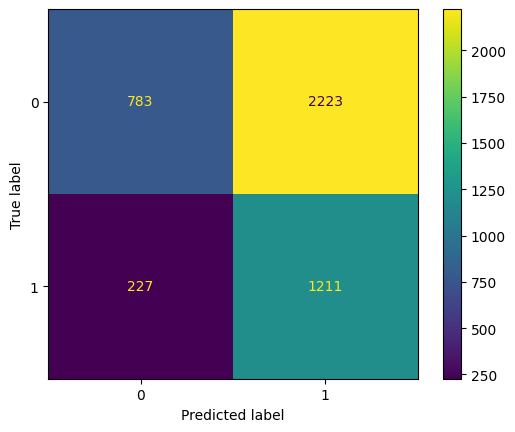

In [15]:
eval_model(trained_model, test_dataset)